In [1]:
# manejo bbdd
import pandas as pd
import numpy as np
import re
import datetime
from scipy.stats import chi2_contingency

#gráficas
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Prophet
from prophet import Prophet
warnings.filterwarnings('ignore')

#estadística
import math
from scipy.stats import norm
from scipy import stats #para box-cox entre otros
from scipy.stats import skew

#preprocesamiento
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#modelos y evaluación
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error,r2_score

In [2]:
datax_1 = pd.read_csv('datax_aircraft_accidents.csv')
datax_1

,date,year,month,day,city,country,operator,ac_type,aboard,aboard_passangers,aboard_crew,fatalities,fatalities_passangers,fatalities_crew,fatality_ratio (%)
0,1908-09-17,1908,9,17,Fort Myer,EE. UU.,Military - U.S. Army,Wright Flyer III,2,1,1,1,1,0,50.0
1,1909-09-07,1909,9,7,Juvisy,France,Unknown,Wright Byplane,1,0,1,1,0,0,100.0
2,1912-07-12,1912,7,12,Atlantic City,EE. UU.,Military - U.S. Navy,Dirigible,5,0,5,5,0,5,100.0
3,1913-08-06,1913,8,6,Victoria,Canadá,Private,Curtiss seaplane,1,0,1,1,0,1,100.0
4,1913-09-09,1913,9,9,Over the North Sea,Over the North Sea,Military - German Navy,Zeppelin L-1 (airship),20,27,4,14,19,3,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,2022-11-21,2022,11,21,Medellín,Colombia,AeroPaca SAS,Piper PA-31-350 Navajo Chieftain,8,6,2,8,6,2,100.0
4994,2023-01-15,2023,1,15,Pokhara,Nepal,Yeti Airlines,ATR 72-500-72-212-A,72,68,4,72,68,4,100.0
4995,2023-09-16,2023,9,16,Barcelos,Brazil,Manaus Aerotaxi,Embraer EMB-110P1 Bandeirante,14,12,2,14,12,2,100.0
4996,2023-10-29,2023,10,29,Rio Branco,Brazil,ART Taxi Aero,Cessna 208B Grand Caravan,12,10,2,12,10,2,100.0


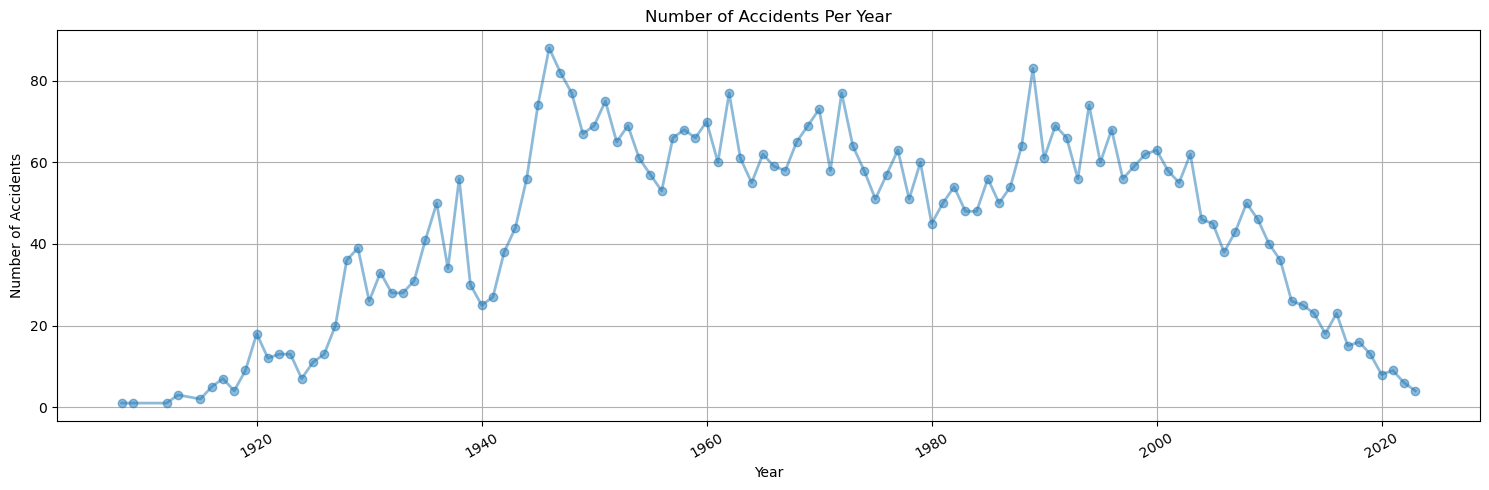

In [3]:
plt.figure(figsize=(15, 5))
#Group data by year
accidents_per_year = datax_1.groupby('year').size()
accidents_per_year.plot(kind='line', marker='o', alpha=0.5, linewidth=2)
plt.title('Number of Accidents Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=30)
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\matte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


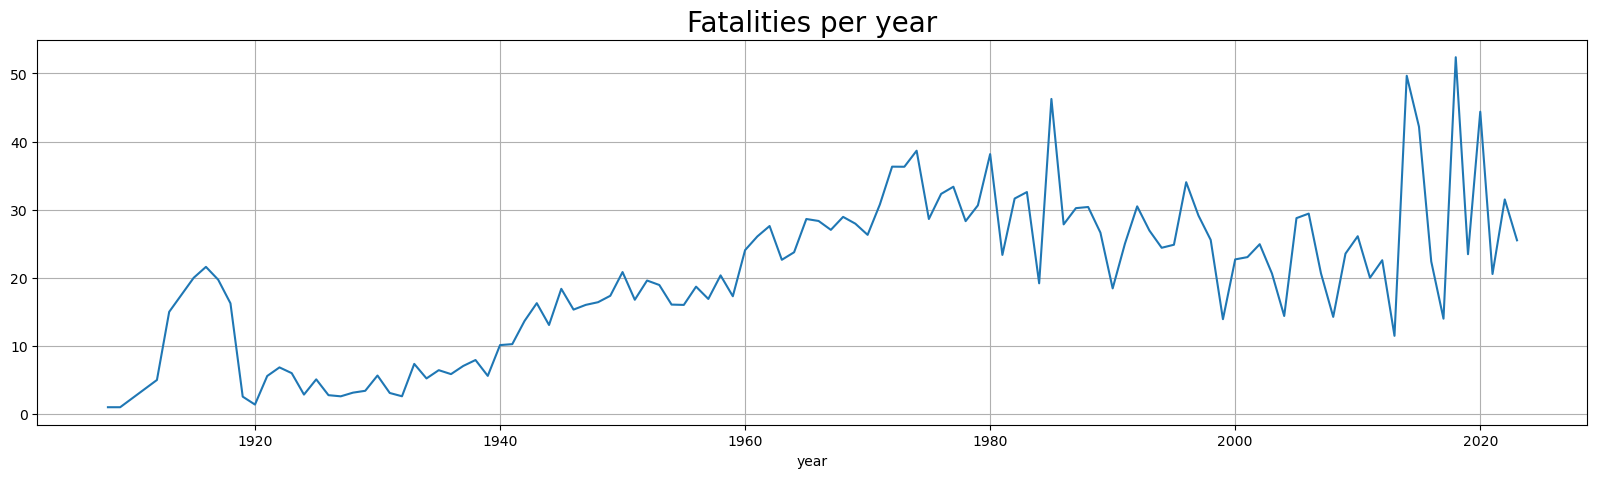

In [4]:
year_fat = datax_1.groupby('year')['fatalities'].mean()
plt.figure(figsize=(20, 5))
sns.lineplot(x=year_fat.index, y=year_fat.values, sort=True)
plt.grid()
plt.title("Fatalities per year", size=20)
plt.show()

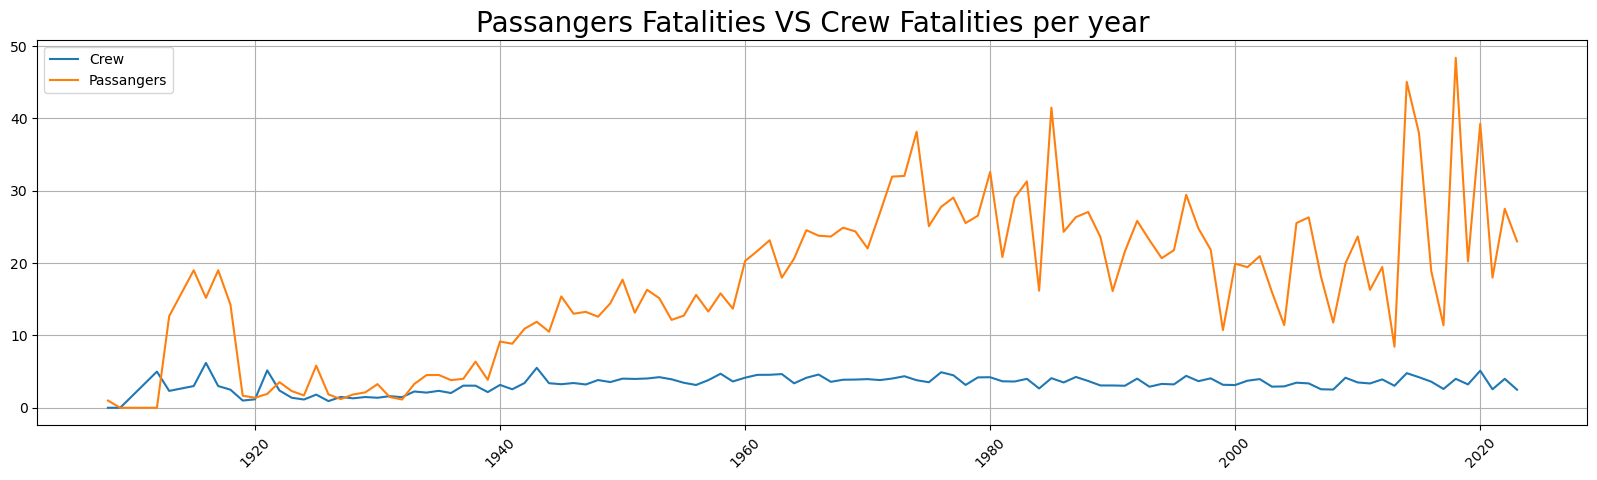

In [5]:
year_fat_pass = datax_1.groupby('year')['fatalities_passangers'].mean()
year_fat_crew = datax_1.groupby('year')['fatalities_crew'].mean()

plt.figure(figsize=(20, 5))
plt.plot(year_fat_crew, label="Crew")
plt.plot(year_fat_pass, label="Passangers")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.title('Passangers Fatalities VS Crew Fatalities per year', size=20)
plt.show()

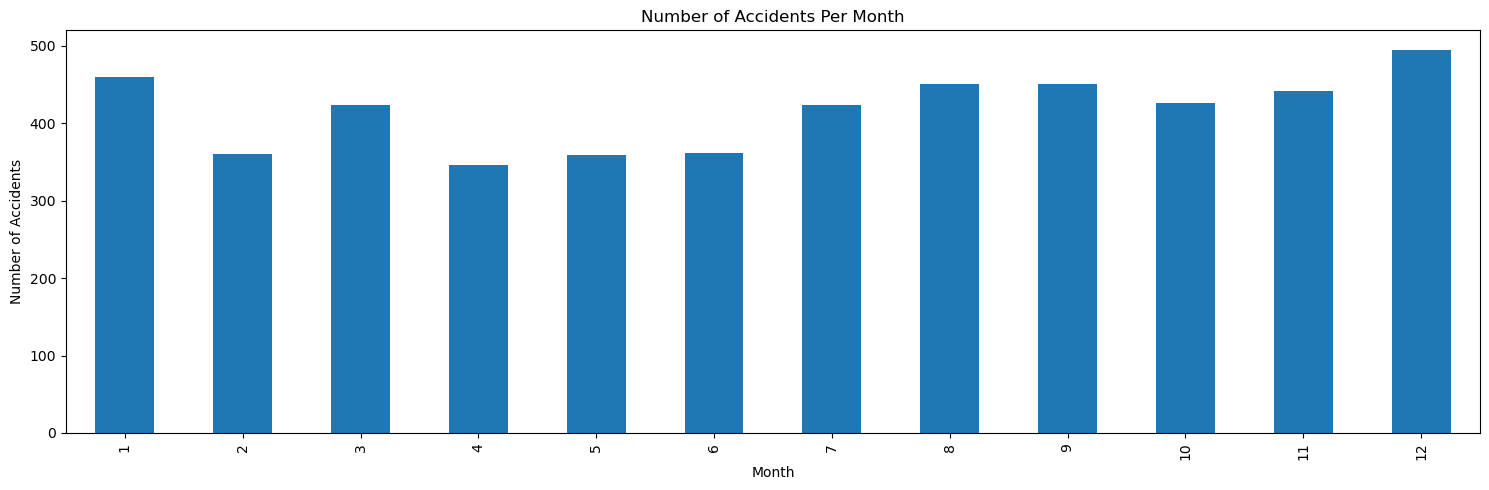

In [6]:
# Plotting the number of accidents for each month
plt.figure(figsize=(15, 5))
#Group data by month
accidents_per_month = datax_1.groupby('month').size()
accidents_per_month.plot(kind='bar')
plt.title('Number of Accidents Per Month')
plt.xlabel('Month')
plt.ylabel('Number of Accidents')
plt.tight_layout()
plt.show()

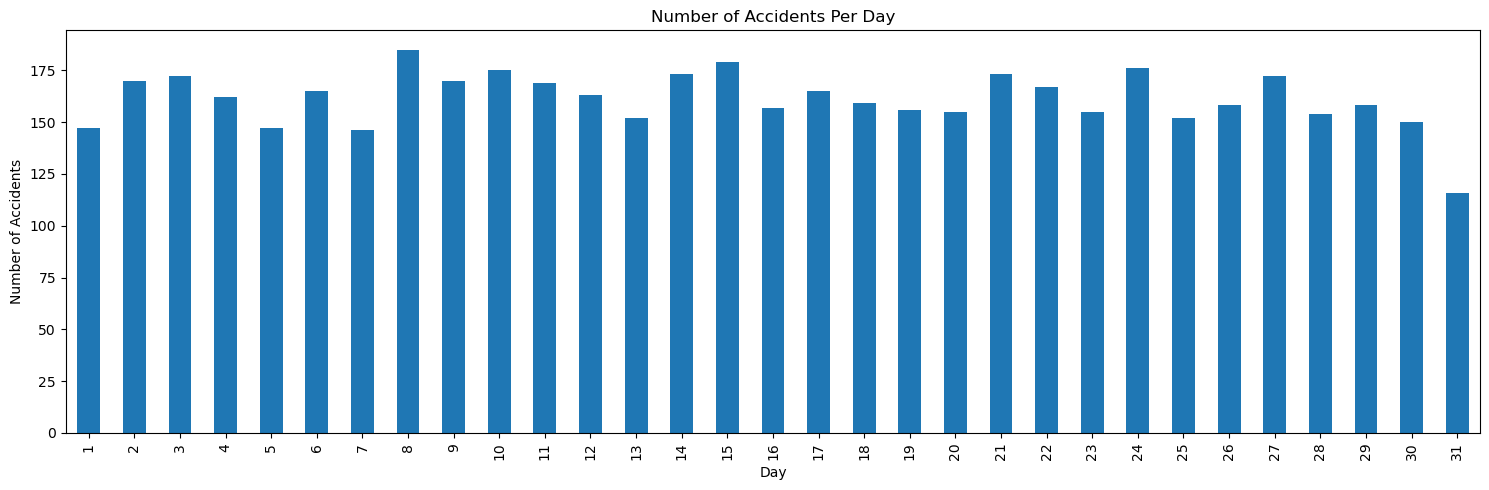

In [7]:
# Plotting the number of accidents for each month
plt.figure(figsize=(15, 5))
#Group data by day
accidents_per_month = datax_1.groupby('day').size()
accidents_per_month.plot(kind='bar')
plt.title('Number of Accidents Per Day')
plt.xlabel('Day')
plt.ylabel('Number of Accidents')
plt.tight_layout()
plt.show()

In [8]:
top_10_operators = datax_1['operator'].value_counts().head(10)
top_10_operators

operator
Aeroflot                               255
Military - U.S. Air Force              140
Air France                              72
Deutsche Lufthansa                      63
United Air Lines                        44
Military - U.S. Army Air Forces         43
China National Aviation Corporation     43
Pan American World Airways              41
American Airlines                       37
US Aerial Mail Service                  35
Name: count, dtype: int64

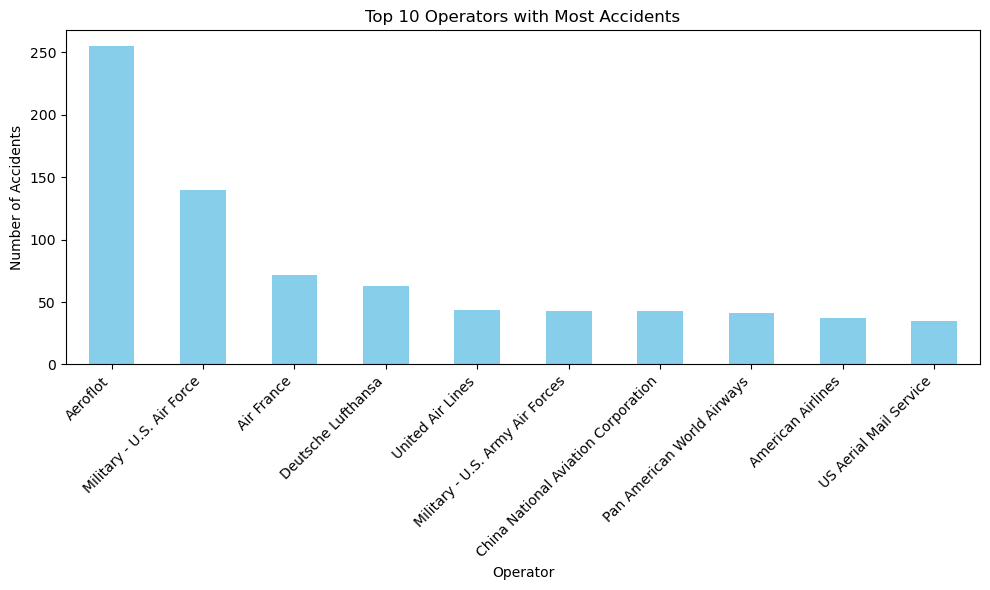

In [9]:
# Contar el número de accidentes para cada operador
accidents_per_operator = datax_1['operator'].value_counts()

# Seleccionar los 10 principales operadores con más accidentes
top_10_operators = accidents_per_operator.head(10)

# Graficar el histograma para los 10 principales operadores
plt.figure(figsize=(10, 6))
top_10_operators.plot(kind='bar', color='skyblue')
plt.title('Top 10 Operators with Most Accidents')
plt.xlabel('Operator')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [10]:
top_10_ac_types = datax_1['ac_type'].value_counts().head(10)
top_10_ac_types

ac_type
Douglas DC-3                                333
de Havilland Canada DHC-6 Twin Otter 300     82
Douglas C-47A                                70
Douglas C-47                                 64
Douglas DC-4                                 38
Antonov AN-26                                35
Yakovlev YAK-40                              35
Junkers JU-52/3m                             31
Douglas DC-6B                                27
Douglas C-47B                                27
Name: count, dtype: int64

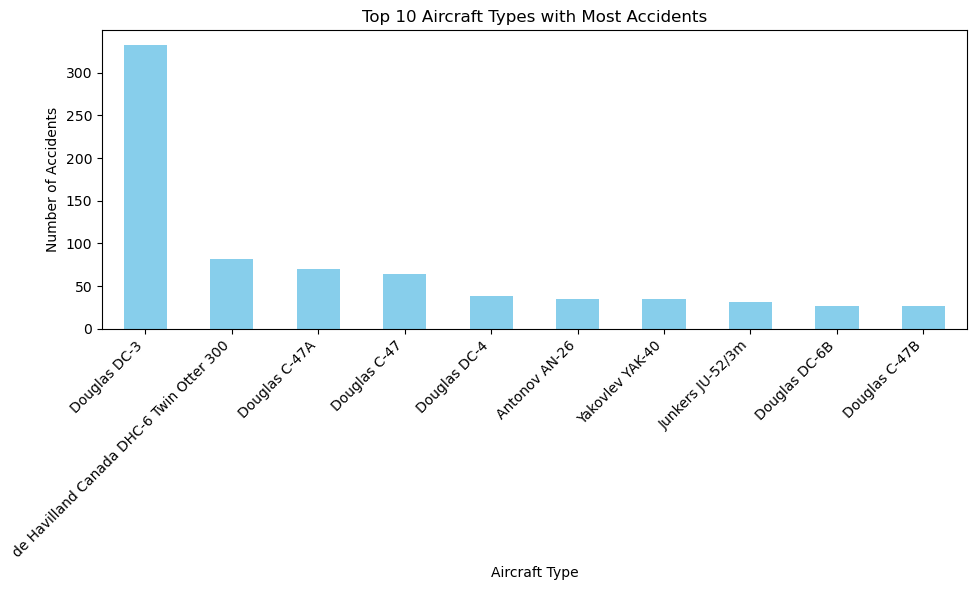

In [11]:
# Contar el número de accidentes para cada tipo de aeronave
accidents_per_ac_type = datax_1['ac_type'].value_counts()

# Seleccionar los 10 principales tipos de aeronaves con más accidentes
top_10_ac_types = accidents_per_ac_type.head(10)

# Graficar el histograma para los 10 principales tipos de aeronaves
plt.figure(figsize=(10, 6))
top_10_ac_types.plot(kind='bar', color='skyblue')
plt.title('Top 10 Aircraft Types with Most Accidents')
plt.xlabel('Aircraft Type')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

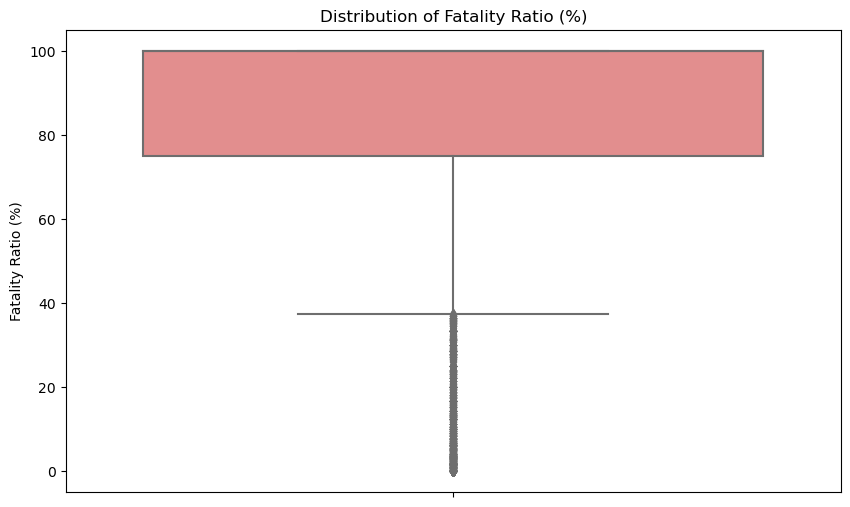

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=datax_1, y='fatality_ratio (%)', color='lightcoral')
plt.title('Distribution of Fatality Ratio (%)')
plt.ylabel('Fatality Ratio (%)')
plt.show()

In [13]:
top_10_countries = datax_1['country'].value_counts().head(10)
top_10_countries

country
EE. UU.      1032
Russia        257
Brazil        177
Colombia      152
Canadá        145
France        123
India         104
England        99
Indonesia      98
China          95
Name: count, dtype: int64

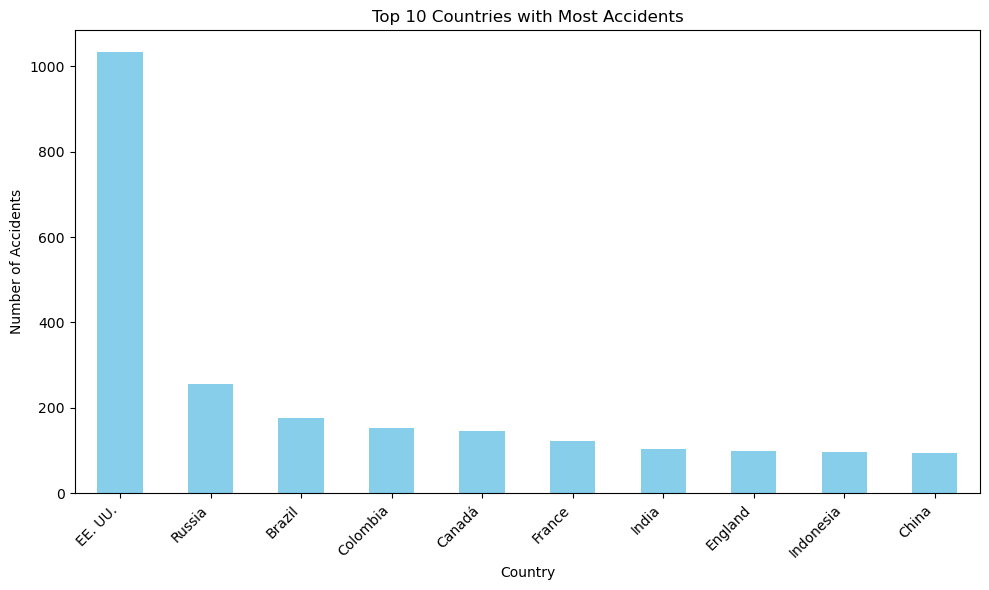

In [14]:
# Contar el número de accidentes para cada país
accidents_per_country = datax_1['country'].value_counts()

# Seleccionar los 10 principales países con más accidentes
top_10_countries = accidents_per_country.head(10)

# Graficar el histograma para los 10 principales países
plt.figure(figsize=(10, 6))
top_10_countries.plot(kind='bar', color='skyblue')
plt.title('Top 10 Countries with Most Accidents')
plt.xlabel('Country')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [15]:
top_10_cities = datax_1['city'].value_counts().head(10)
print("\nTop 10 cities:\n", top_10_cities)


Top 10 cities:
 city
Moscow            19
Manila            15
New York          15
Cairo             13
Sao Paulo         13
Rio de Janeiro    12
Bogota            12
Near Moscow       12
Chicago           11
Atlantic Ocean    11
Name: count, dtype: int64


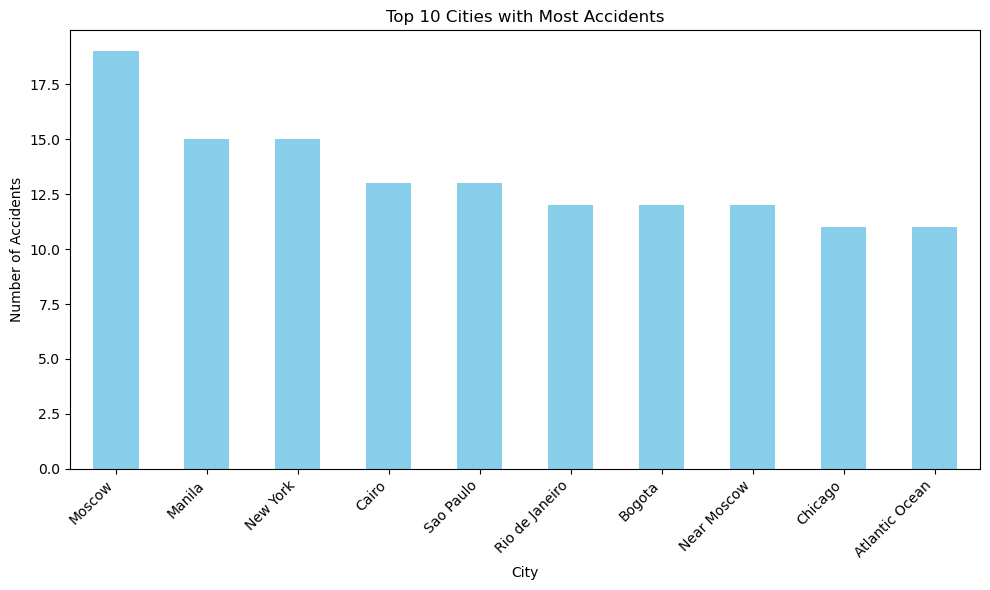

In [16]:
# Contar el número de accidentes para cada ciudad
accidents_per_city = datax_1['city'].value_counts()

# Seleccionar los 10 principales ciudades con más accidentes
top_10_cities = accidents_per_city.head(10)

# Graficar el histograma para los 10 principales ciudades
plt.figure(figsize=(10, 6))
top_10_cities.plot(kind='bar', color='skyblue')
plt.title('Top 10 Cities with Most Accidents')
plt.xlabel('City')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [17]:
# Filtrar las entradas donde el país sea Spain
spain_data = datax_1[datax_1['country'] == 'Spain']

# Contar el número de accidentes para cada ciudad en España
accidents_spain = spain_data['country'].value_counts()
accidents_spain

country
Spain    64
Name: count, dtype: int64

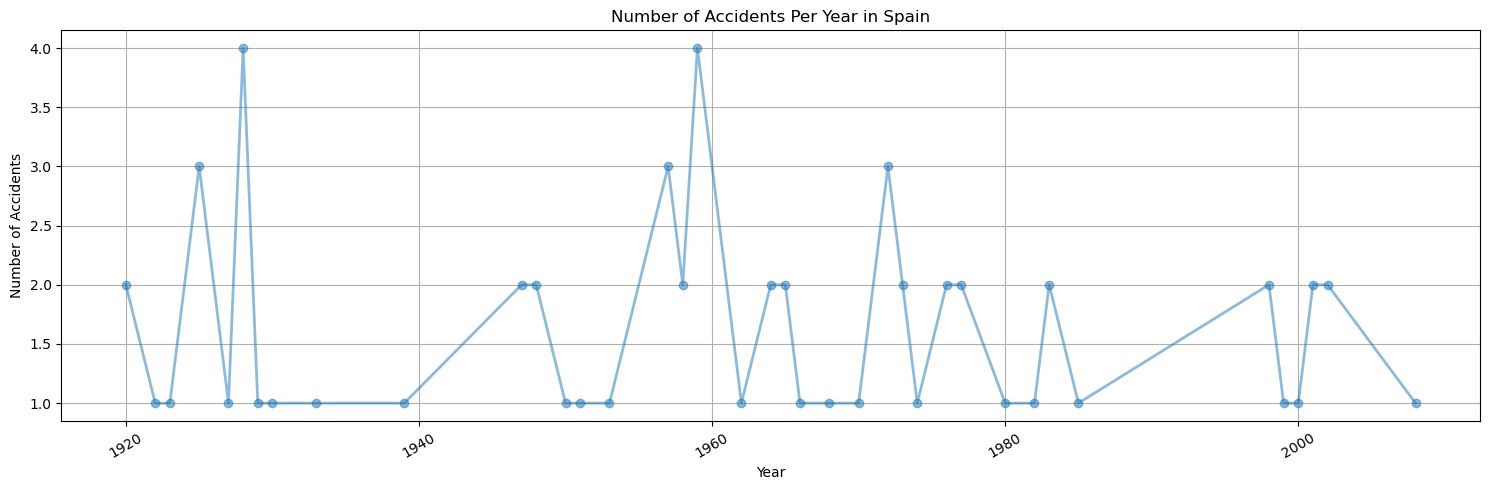

In [18]:
# Filtrar los accidentes ocurridos en España
accidents_spain = datax_1[datax_1['country'] == 'Spain']

# Agrupar los datos por año y contar el número de accidentes
accidents_per_year_spain = accidents_spain.groupby('year').size()

# Trazar el gráfico
plt.figure(figsize=(15, 5))
accidents_per_year_spain.plot(kind='line', marker='o', alpha=0.5, linewidth=2)
plt.title('Number of Accidents Per Year in Spain')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=30)
plt.grid(True)
plt.tight_layout()
plt.show()

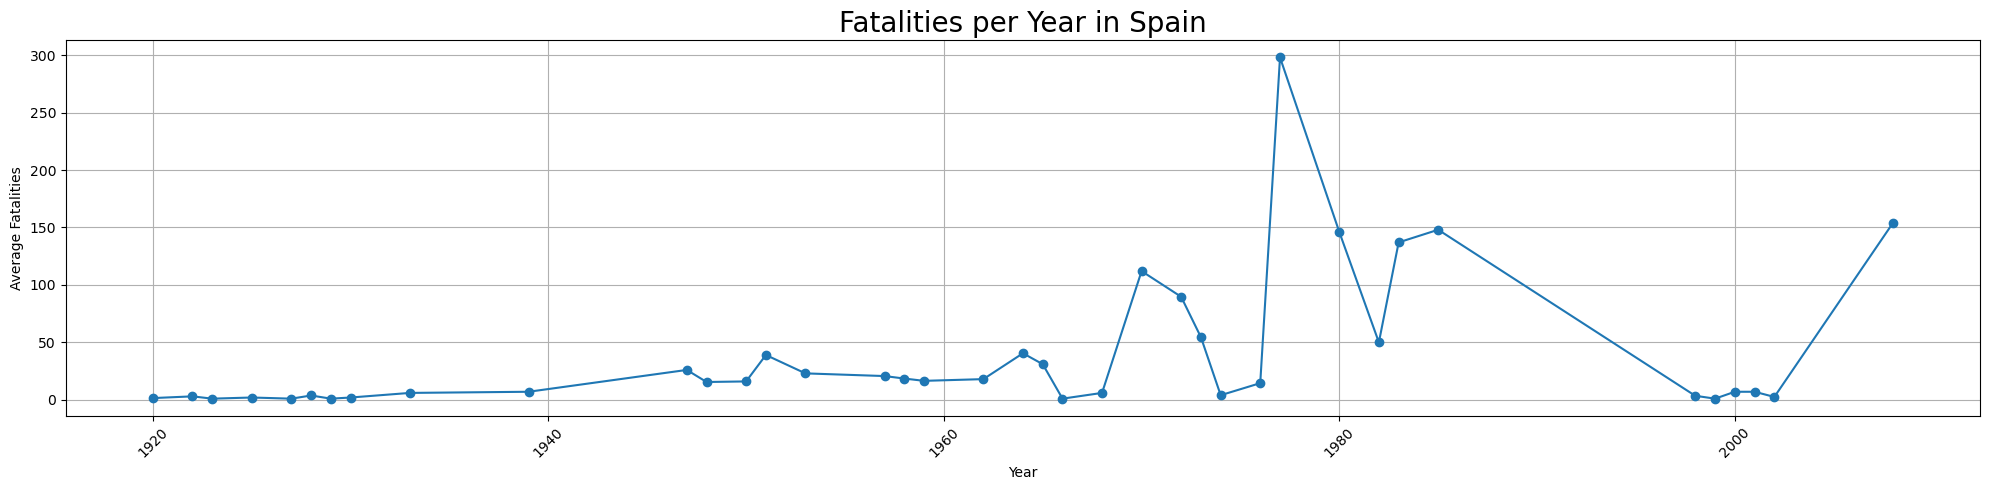

In [19]:
# Filtrar los accidentes ocurridos en España
accidents_spain = datax_1[datax_1['country'] == 'Spain']

# Calcular el promedio de fatalidades por año en España
yearly_avg_fatalities_spain = accidents_spain.groupby('year')['fatalities'].mean()

# Trazar el gráfico
plt.figure(figsize=(20, 5))
plt.plot(yearly_avg_fatalities_spain.index, yearly_avg_fatalities_spain.values, marker='o', linestyle='-')
plt.grid(True)
plt.title("Fatalities per Year in Spain", size=20)
plt.xlabel("Year")
plt.ylabel("Average Fatalities")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

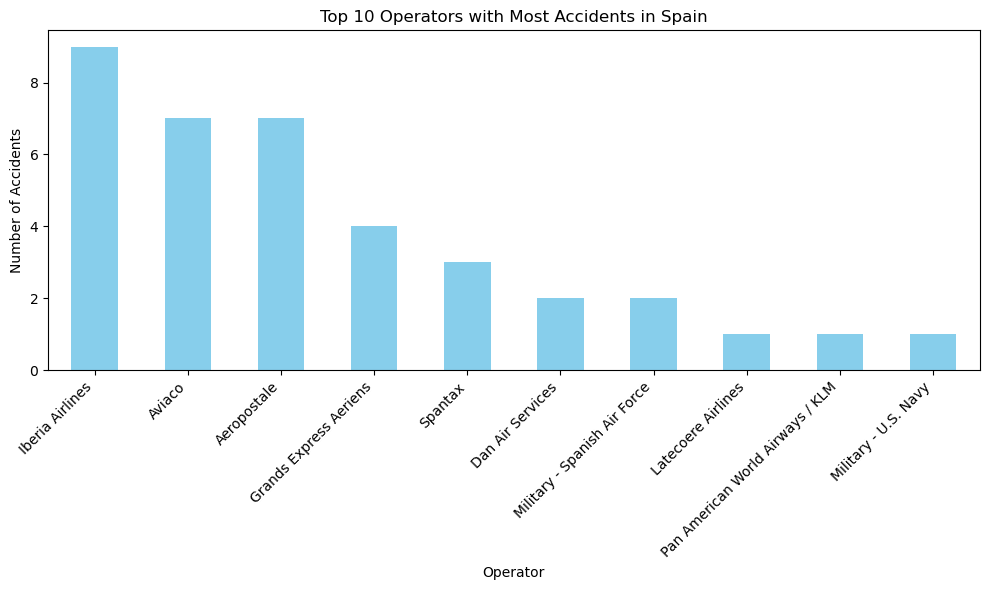

In [20]:
# Filtrar los accidentes ocurridos en España
accidents_spain = datax_1[datax_1['country'] == 'Spain']

# Contar el número de accidentes para cada operador en España
accidents_per_operator_spain = accidents_spain['operator'].value_counts()

# Seleccionar los 10 principales operadores con más accidentes en España
top_10_operators_spain = accidents_per_operator_spain.head(10)

# Graficar el histograma para los 10 principales operadores en España
plt.figure(figsize=(10, 6))
top_10_operators_spain.plot(kind='bar', color='skyblue')
plt.title('Top 10 Operators with Most Accidents in Spain')
plt.xlabel('Operator')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

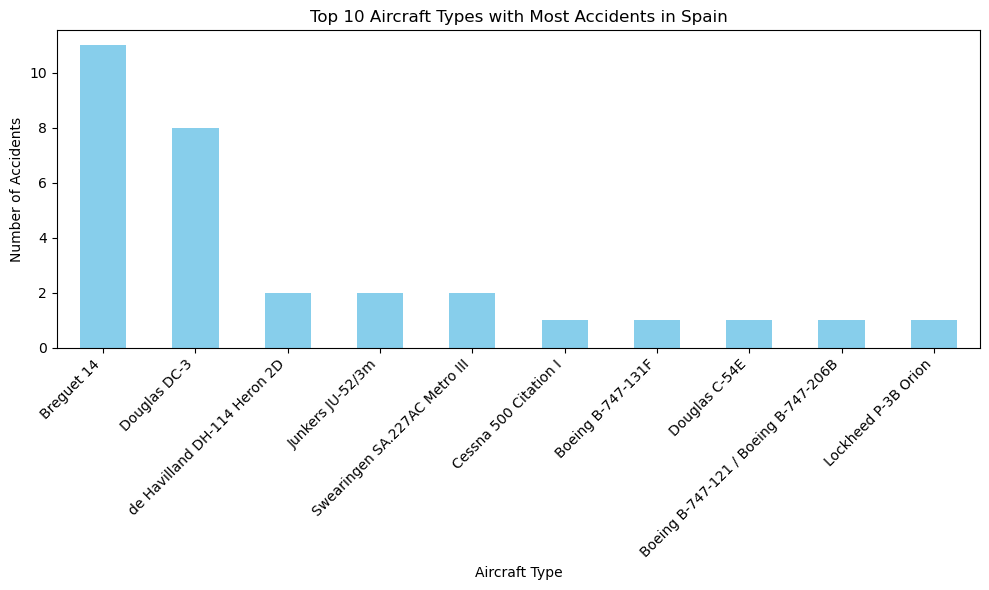

In [21]:
# Filtrar los accidentes ocurridos en España
accidents_spain = datax_1[datax_1['country'] == 'Spain']

# Contar el número de accidentes para cada tipo de aeronave en España
accidents_per_ac_type_spain = accidents_spain['ac_type'].value_counts()

# Seleccionar los 10 principales tipos de aeronaves con más accidentes en España
top_10_ac_types_spain = accidents_per_ac_type_spain.head(10)

# Graficar el histograma para los 10 principales tipos de aeronaves en España
plt.figure(figsize=(10, 6))
top_10_ac_types_spain.plot(kind='bar', color='skyblue')
plt.title('Top 10 Aircraft Types with Most Accidents in Spain')
plt.xlabel('Aircraft Type')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [22]:
# Filtrar los accidentes ocurridos en España
accidents_spain = datax_1[datax_1['country'] == 'Spain']

# Contar el número de accidentes por ciudad en España
accidents_per_city_spain = accidents_spain['city'].value_counts()

# Seleccionar las 10 principales ciudades con más accidentes en España
top_10_cities_spain = accidents_per_city_spain.head(10)
top_10_cities_spain

city
Barcelona       6
Tenerife        5
Madrid          3
Albacete        2
Alicante        2
Almeria         2
Near Malaga     2
Near Madrid     2
Near Huete      1
Off Tenerife    1
Name: count, dtype: int64

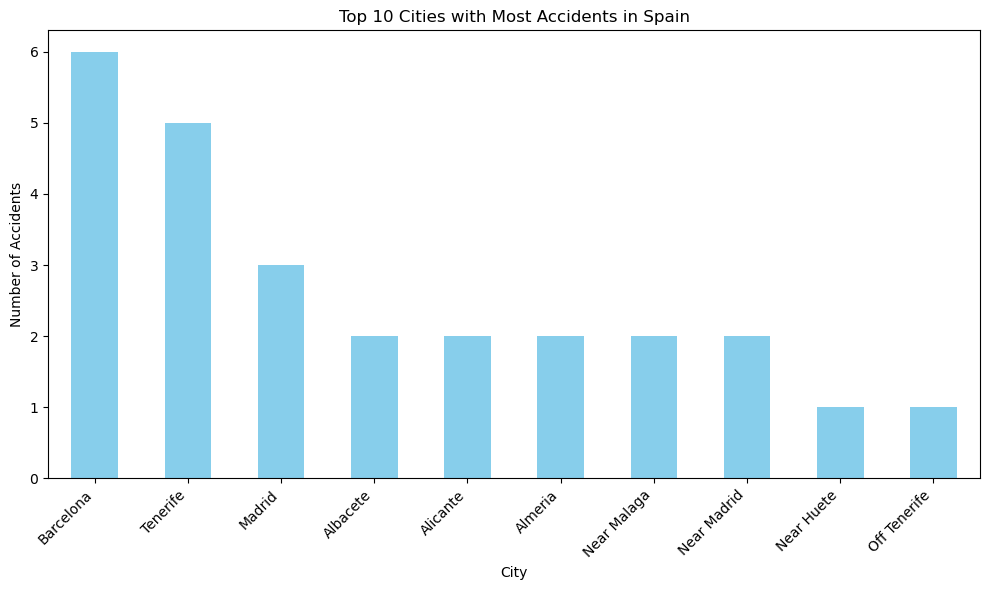

In [23]:
# Filtrar los datos solo por el país "Spain"
accidents_spain = datax_1[datax_1['country'] == 'Spain']

# Contar el número de accidentes por ciudad en España
accidents_per_city_spain = accidents_spain['city'].value_counts()

# Seleccionar las 10 principales ciudades con más accidentes en España
top_10_cities_spain = accidents_per_city_spain.head(10)

# Graficar el histograma para las 10 principales ciudades en España
plt.figure(figsize=(10, 6))
top_10_cities_spain.plot(kind='bar', color='skyblue')
plt.title('Top 10 Cities with Most Accidents in Spain')
plt.xlabel('City')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

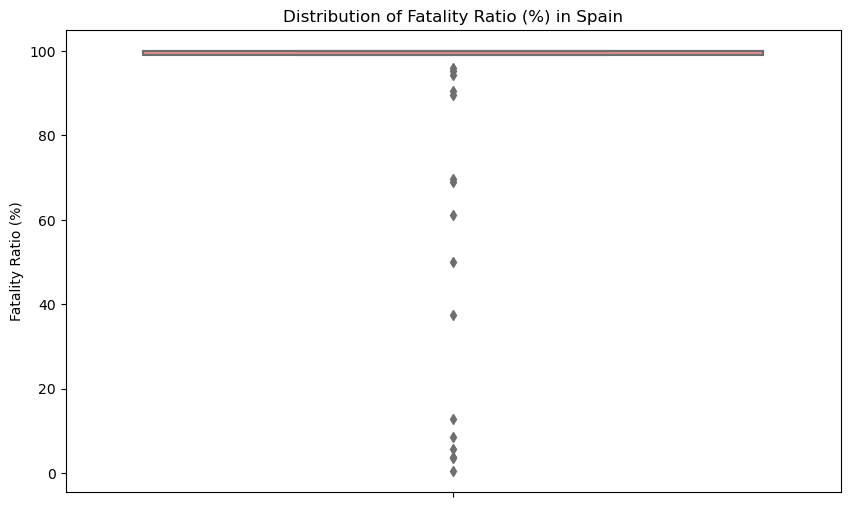

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar los datos solo por el país "Spain"
data_spain = datax_1[datax_1['country'] == 'Spain']

# Graficar el boxplot para la tasa de mortalidad en España
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_spain, y='fatality_ratio (%)', color='lightcoral')
plt.title('Distribution of Fatality Ratio (%) in Spain')
plt.ylabel('Fatality Ratio (%)')
plt.show()

In [50]:
# Obtener los 10 accidentes con más fatalidades
top_10_fatalities = datax_1.nlargest(10, 'fatalities')
top_10_fatalities

,date,year,month,day,city,country,operator,ac_type,aboard,aboard_passangers,aboard_crew,fatalities,fatalities_passangers,fatalities_crew,fatality_ratio (%)
2885,1977-03-27,1977,3,27,Tenerife,Spain,Pan American World Airways / KLM,Boeing B-747-121 / Boeing B-747-206B,644,614,30,583,560,23,90.527950
3324,1985-08-12,1985,8,12,Mt. Osutaka,Japan,Japan Air Lines,Boeing B-747-SR46,524,509,15,520,505,15,99.236641
4039,1996-11-12,1996,11,12,Near Charkhi Dadri,India,Saudi Arabian Airlines / Kazakhstan Airlines,Boeing B-747-168B / Ilyushin IL-76TD,349,316,33,349,316,33,100.000000
2720,1974-03-03,1974,3,3,Near Ermenonville,France,Turkish Airlines (THY),McDonnell Douglas DC-10-10,346,335,11,346,335,11,100.000000
3320,1985-06-23,1985,6,23,Atlantic Ocean,110 miles West of Ireland,Air India,Boeing B-747-237B,329,307,22,329,307,22,100.000000
3076,1980-08-19,1980,8,19,Riyadh,Saudi Arabia,Saudi Arabian Airlines,Lockheed 1011-200 TriStar,301,287,14,301,287,14,100.000000
4876,2014-07-17,2014,7,17,Hrabove,Ukraine,Malaysia Airlines,Boeing 777-2H6ER,298,283,15,298,283,15,100.000000
3482,1988-07-03,1988,7,3,Over the Persian Gulf,Iran,Iran Air,Airbus A300B2-203,290,278,12,290,278,12,100.000000
4415,2003-02-19,2003,2,19,Near Shahdad,Iran,Military - Islamic Revolution's Guards Corps,Ilyushin Il-76MD,275,257,18,275,257,18,100.000000
3007,1979-05-25,1979,5,25,Chicago O'Hare,EE. UU.,American Airlines,McDonnell Douglas DC-10-10,271,258,13,271,258,13,100.000000


In [54]:
datax_1['year'] = pd.to_datetime(datax_1['year'], format='%Y')
datax_1.sample(5)

,date,year,month,day,city,country,operator,ac_type,aboard,aboard_passangers,aboard_crew,fatalities,fatalities_passangers,fatalities_crew,fatality_ratio (%)
2525,1971-05-25,1971-01-01,5,25,Santiago,Chile,\tAerolineas Flecha Austral - ALFA,\tCurtiss C-46,4,2,2,4,2,2,100.000000
3935,1995-04-23,1995-01-01,4,23,Lagos,Nigeria,Bristow Helicopters,de Havilland Canada DHC-6 Twin Otter 300,9,7,2,1,0,1,11.111111
409,1936-03-05,1936-01-01,3,5,Near Tengya,China,China National Aviation Corporation,Ford 5-AT-D Tri-Motor,6,3,3,0,0,0,0.000000
4508,2004-11-27,2004-01-01,11,27,Near Bagram,Afghanstan,Presidental Airways Inc. - Air Taxi,CASA 212-CC,6,3,3,6,3,3,100.000000
507,1938-05-27,1938-01-01,5,27,Langeoog,Germany,Deutsche Lufthansa,Heinkel 116,3,0,3,3,0,3,100.000000


In [56]:
#Prophet
# Seleccionar las columnas 'Year' y 'Fatalities' del DataFrame original
prophet_data1 = datax_1[['year', 'fatalities']]
# Guardar el nuevo DataFrame en un archivo CSV
prophet_data1.to_csv('prophet_aircraft_accidents.csv', index=False)

In [58]:
prophet_data1

,year,fatalities
0,1908-01-01,1
1,1909-01-01,1
2,1912-01-01,5
3,1913-01-01,1
4,1913-01-01,14
...,...,...
4993,2022-01-01,8
4994,2023-01-01,72
4995,2023-01-01,14
4996,2023-01-01,12


In [60]:
prophet_data1.rename(columns = {'year':'ds', 'fatalities':'y'}, inplace = True)
prophet_data1

C:\Users\matte\AppData\Local\Temp\ipykernel_29384\1754616070.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_data1.rename(columns = {'year':'ds', 'fatalities':'y'}, inplace = True)


,ds,y
0,1908-01-01,1
1,1909-01-01,1
2,1912-01-01,5
3,1913-01-01,1
4,1913-01-01,14
...,...,...
4993,2022-01-01,8
4994,2023-01-01,72
4995,2023-01-01,14
4996,2023-01-01,12


In [62]:
m = Prophet()
m.fit(prophet_data1)

14:16:26 - cmdstanpy - INFO - Chain [1] start processing
14:16:26 - cmdstanpy - INFO - Chain [1] done processing


In [64]:
periods = 6 * 365  # Predicciones hasta el año 2030
# Crear el DataFrame para el periodo futuro
future = m.make_future_dataframe(periods=periods)
# Mostrar las últimas filas del DataFrame
print(future.tail())

             ds
2298 2028-12-26
2299 2028-12-27
2300 2028-12-28
2301 2028-12-29
2302 2028-12-30


C:\Users\matte\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\matte\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


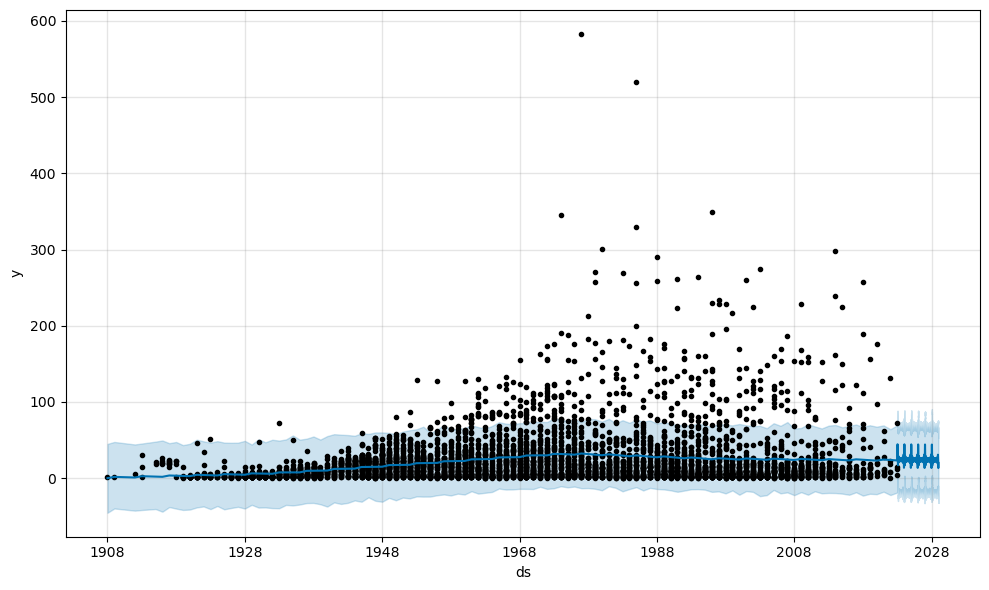

In [67]:
forecast = m.predict(future)
fig1 = m.plot(forecast)

C:\Users\matte\anaconda3\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\matte\anaconda3\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\matte\anaconda3\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np

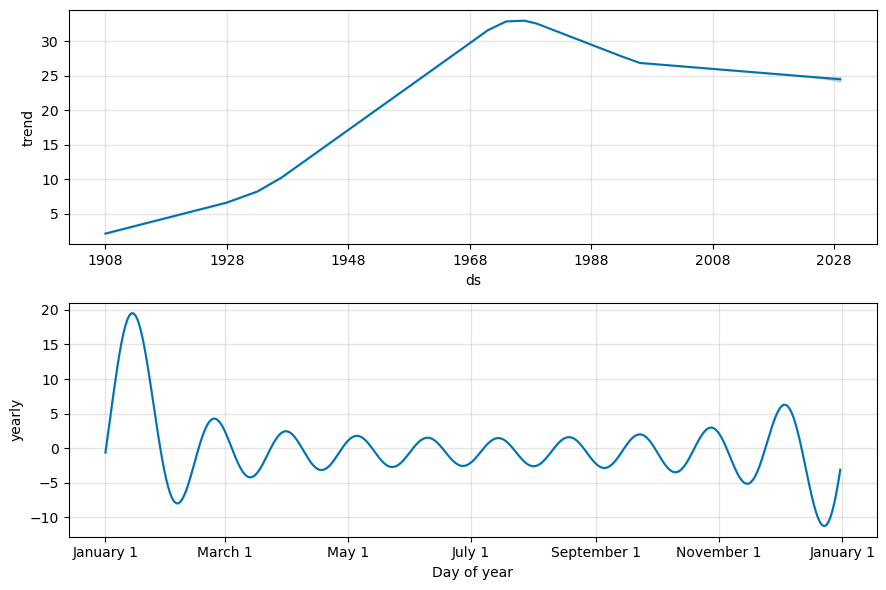

In [70]:
fig2 = m.plot_components(forecast)